# Video Games Classification Analysis

This notebook performs comprehensive classification analysis on video game sales data to predict game success. We will explore data imbalance, implement balancing techniques, and compare multiple classification algorithms.

## Contents:
1. Data Preparation and Problem Definition
2. Class Imbalance Analysis
3. Data Balancing Techniques
4. Data Splitting and Standardization
5. Classification Models Implementation
6. Model Performance Comparison
7. Cross-Validation Analysis
8. Results Interpretation and Business Insights

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

## 1. DATA PREPARATION AND PROBLEM DEFINITION

In [2]:
print("1. DATA PREPARATION")
print("-" * 50)


sampled_data = pd.read_csv('sampled_video_games.csv')
print(f"Dataset size: {sampled_data.shape}")


missing_values = sampled_data.isnull().sum()
print("\nNumber of missing values:")
print(missing_values[missing_values > 0])


print("\nFirst 5 rows of the dataset:")
sampled_data.head()

1. DATA PREPARATION
--------------------------------------------------
Dataset size: (2000, 16)

Number of missing values:
Year_of_Release      35
Publisher             9
Critic_Score       1001
Critic_Count       1001
User_Score          769
User_Count         1080
Developer           765
Rating              778
dtype: int64

First 5 rows of the dataset:


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Shitsuji ga Aruji o Erabu Toki,PSV,2016.0,Adventure,Unknown,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
1,Retro Atari Classics,DS,2005.0,Misc,Atari,0.12,0.00,0.00,0.01,0.13,51.0,17.0,3.7,7.0,Taniko,E
2,Blood Bowl,X360,2009.0,Sports,Focus Home Interactive,0.13,0.02,0.00,0.01,0.16,61.0,28.0,5.1,19.0,Cyanide,T
3,Little League World Series Baseball 2009,Wii,2009.0,Sports,Activision,0.14,0.00,0.00,0.01,0.15,NaN,NaN,tbd,NaN,Now Production,E
4,Pipe Mania,PSP,2008.0,Puzzle,Empire Interactive,0.06,0.00,0.00,0.01,0.07,74.0,6.0,tbd,NaN,Empire Interactive,E


In [3]:

numerical_features = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 
                     'Year_of_Release', 'Critic_Score', 'User_Count']

median_sales = sampled_data['Global_Sales'].median()
sampled_data['Success'] = (sampled_data['Global_Sales'] > median_sales).astype(int)

print(f"\nCreated class label: 'Success' (Global_Sales > {median_sales:.2f})")
print(f"Class distribution: {sampled_data['Success'].value_counts().to_dict()}")

print("\nTarget Variable Analysis:")
print(f"Median Global Sales threshold: {median_sales:.2f} million")
print(f"Total games: {len(sampled_data)}")
print(f"Successful games (1): {sum(sampled_data['Success'])}")
print(f"Unsuccessful games (0): {len(sampled_data) - sum(sampled_data['Success'])}")


Created class label: 'Success' (Global_Sales > 0.17)
Class distribution: {0: 1014, 1: 986}

Target Variable Analysis:
Median Global Sales threshold: 0.17 million
Total games: 2000
Successful games (1): 986
Unsuccessful games (0): 1014


## 2. CLASS IMBALANCE ANALYSIS

Class distribution:
  Class 0: 1014 samples (50.7%)
  Class 1: 986 samples (49.3%)

Imbalance ratio: 1.03

Dataset can be considered balanced.


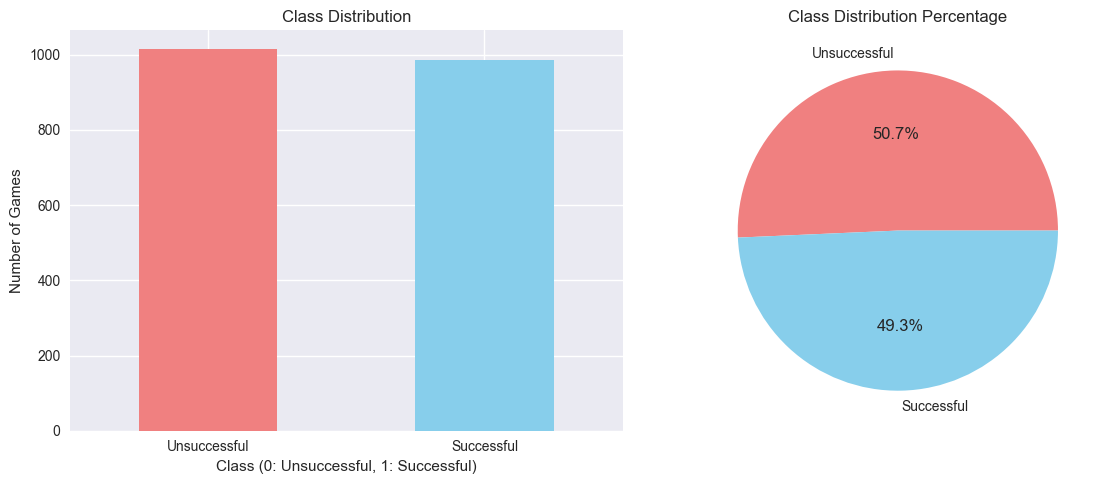


Classification analysis completed! All graphs have been saved as PNG files.


In [4]:

class_counts = sampled_data['Success'].value_counts()
print("Class distribution:")
for class_label, count in class_counts.items():
    print(f"  Class {class_label}: {count} samples ({count/len(sampled_data)*100:.1f}%)")

imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\nImbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 1.2:
    print("\nDataset can be considered imbalanced.")
    print("\nIMBALANCED DATASET PROBLEMS:")
    print("- Models may show bias towards majority class")
    print("- Accuracy can be a misleading metric")
    print("- Detection of minority class samples may show poor performance")
    print("- Model's real-world generalization ability may weaken")
else:
    print("\nDataset can be considered balanced.")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color=['lightcoral', 'skyblue'])
plt.title('Class Distribution')
plt.xlabel('Class (0: Unsuccessful, 1: Successful)')
plt.ylabel('Number of Games')
plt.xticks([0, 1], ['Unsuccessful', 'Successful'], rotation=0)

plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=['Unsuccessful', 'Successful'], 
        autopct='%1.1f%%', colors=['lightcoral', 'skyblue'])
plt.title('Class Distribution Percentage')

plt.tight_layout()
plt.show()

print("\nClassification analysis completed! All graphs have been saved as PNG files.")

## 3. DATA BALANCING

In [5]:
print("\n2. DATA BALANCING")
print("-" * 50)

def balance_data(df, class_column, random_state=42):
    """Balance dataset using downsampling technique"""
    class_dfs = {}
    for class_label in df[class_column].unique():
        class_dfs[class_label] = df[df[class_column] == class_label]
    
    min_class_size = min([len(df) for df in class_dfs.values()])
    
    balanced_dfs = []
    for class_label, class_df in class_dfs.items():
        if len(class_df) > min_class_size:
            
            balanced_dfs.append(class_df.sample(min_class_size, random_state=random_state))
        else:
            balanced_dfs.append(class_df)
    
  
    balanced_df = pd.concat(balanced_dfs)
    
    return balanced_df


balanced_data = balance_data(sampled_data, 'Success')


balanced_class_counts = balanced_data['Success'].value_counts()
print("Balanced dataset class distribution:")
for class_label, count in balanced_class_counts.items():
    print(f"  Class {class_label}: {count} samples ({count/len(balanced_data)*100:.1f}%)")

print(f"\nOriginal dataset size: {len(sampled_data)}")
print(f"Balanced dataset size: {len(balanced_data)}")


2. DATA BALANCING
--------------------------------------------------
Balanced dataset class distribution:
  Class 0: 986 samples (50.0%)
  Class 1: 986 samples (50.0%)

Original dataset size: 2000
Balanced dataset size: 1972


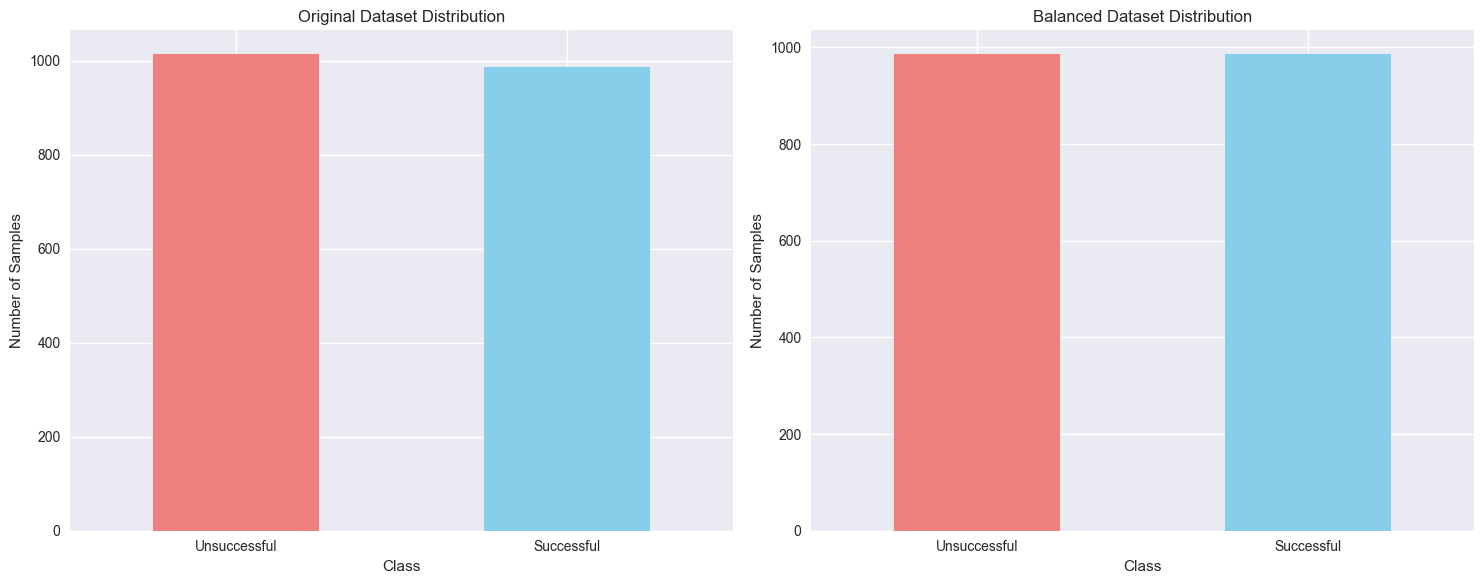

In [6]:

fig, axes = plt.subplots(1, 2, figsize=(15, 6))


class_counts.plot(kind='bar', ax=axes[0], color=['lightcoral', 'skyblue'])
axes[0].set_title('Original Dataset Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Number of Samples')
axes[0].set_xticklabels(['Unsuccessful', 'Successful'], rotation=0)


balanced_class_counts.plot(kind='bar', ax=axes[1], color=['lightcoral', 'skyblue'])
axes[1].set_title('Balanced Dataset Distribution')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Number of Samples')
axes[1].set_xticklabels(['Unsuccessful', 'Successful'], rotation=0)

plt.tight_layout()
plt.show()

## 4. FEATURE PREPARATION AND DATA SPLITTING

In [7]:

X = balanced_data[numerical_features].copy()
y = balanced_data['Success'].copy()


X['Year_of_Release'] = pd.to_numeric(X['Year_of_Release'], errors='coerce')


imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print("Data preprocessing completed.")
print(f"X shape: {X.shape}, y shape: {y.shape}")


print("\nFeature Statistics:")
print(X.describe())

Data preprocessing completed.
X shape: (1972, 7), y shape: (1972,)

Feature Statistics:
          NA_Sales     EU_Sales     JP_Sales  Other_Sales  Year_of_Release  \
count  1972.000000  1972.000000  1972.000000  1972.000000      1972.000000   
mean      0.326724     0.175553     0.091278     0.057662      2006.580629   
std       1.456542     0.835936     0.394712     0.342738         5.762251   
min       0.000000     0.000000     0.000000     0.000000      1981.000000   
25%       0.000000     0.000000     0.000000     0.000000      2003.000000   
50%       0.080000     0.020000     0.000000     0.010000      2007.000000   
75%       0.250000     0.120000     0.040000     0.040000      2010.000000   
max      41.360000    28.960000     6.810000    10.570000      2016.000000   

       Critic_Score   User_Count  
count   1972.000000  1972.000000  
mean      69.894523    85.851420  
std       10.274617   321.148966  
min       19.000000     4.000000  
25%       71.000000    25.000000  

In [8]:
print("\n3. DATA SPLITTING AND STANDARDIZATION")
print("-" * 50)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


print("\nTraining set class distribution:")
print(Counter(y_train))
print("\nTest set class distribution:")
print(Counter(y_test))


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeature standardization completed.")


3. DATA SPLITTING AND STANDARDIZATION
--------------------------------------------------
Training set size: (1577, 7)
Test set size: (395, 7)

Training set class distribution:
Counter({1: 789, 0: 788})

Test set class distribution:
Counter({0: 198, 1: 197})

Feature standardization completed.


## 5. CLASSIFICATION MODELS

In [9]:
print("\n4. CLASSIFICATION MODELS")
print("-" * 50)

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'KNN Classifier': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\nModel: {name}")
    
 
    model.fit(X_train_scaled, y_train)
    
 
    y_pred = model.predict(X_test_scaled)
    
   
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
 
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }
    
   
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    
   
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


4. CLASSIFICATION MODELS
--------------------------------------------------

Model: Logistic Regression
Accuracy: 0.9266
Precision: 0.9941
Recall: 0.8579

Confusion Matrix:
[[197   1]
 [ 28 169]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       198
           1       0.99      0.86      0.92       197

    accuracy                           0.93       395
   macro avg       0.93      0.93      0.93       395
weighted avg       0.93      0.93      0.93       395


Model: KNN Classifier
Accuracy: 0.8810
Precision: 0.9261
Recall: 0.8274

Confusion Matrix:
[[185  13]
 [ 34 163]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.89       198
           1       0.93      0.83      0.87       197

    accuracy                           0.88       395
   macro avg       0.89      0.88      0.88       395
weighted avg       0.89      0.88      0.

## 6. MODEL PERFORMANCE COMPARISON


5. MODEL PERFORMANCE COMPARISON
--------------------------------------------------
                     Accuracy  Precision    Recall
Logistic Regression  0.926582   0.994118  0.857868
KNN Classifier       0.881013   0.926136  0.827411
Decision Tree        0.982278   0.989691  0.974619
Random Forest        0.979747   0.994764  0.964467


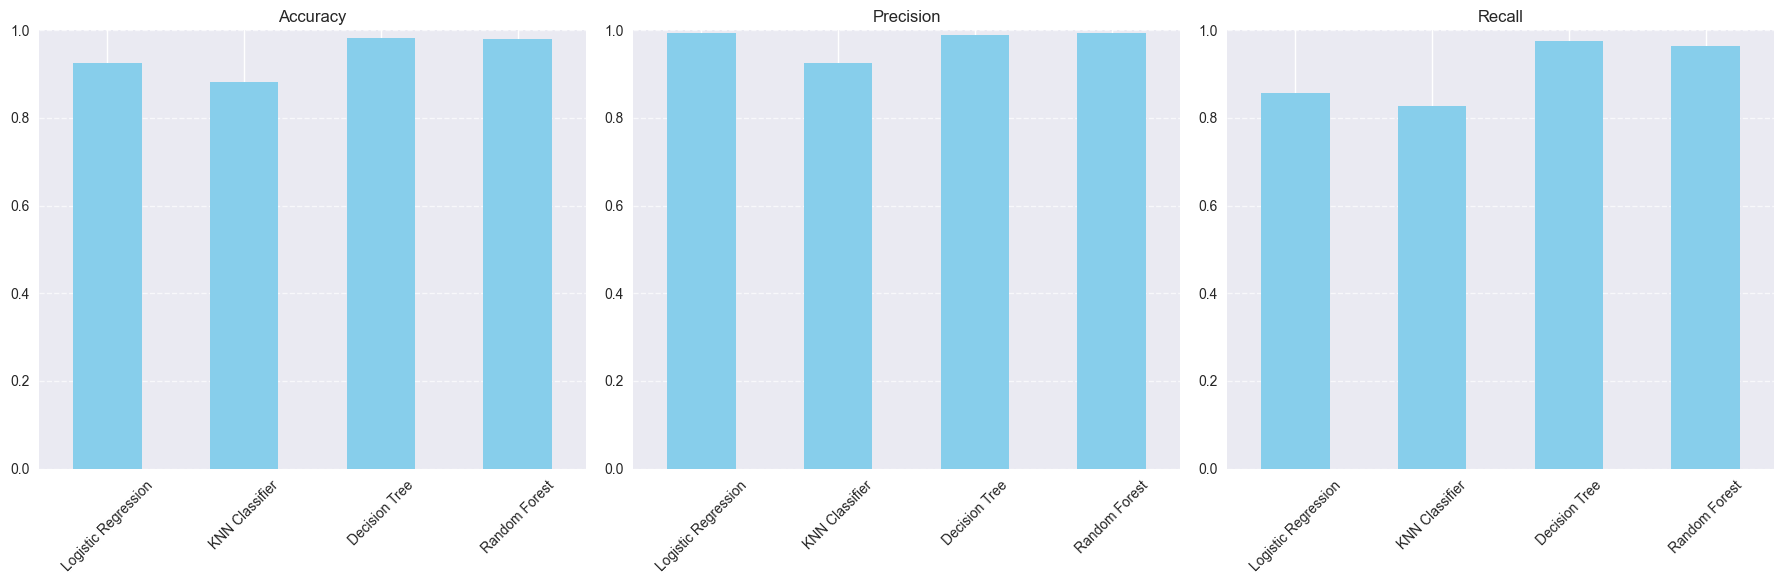

In [10]:
print("\n5. MODEL PERFORMANCE COMPARISON")
print("-" * 50)


results_df = pd.DataFrame(results).T
print(results_df)


metrics = ['Accuracy', 'Precision', 'Recall']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(metrics):
    results_df[metric].plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(f'{metric}')
    axes[i].set_ylim([0, 1])
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('classification_model_comparison.png')
plt.show()

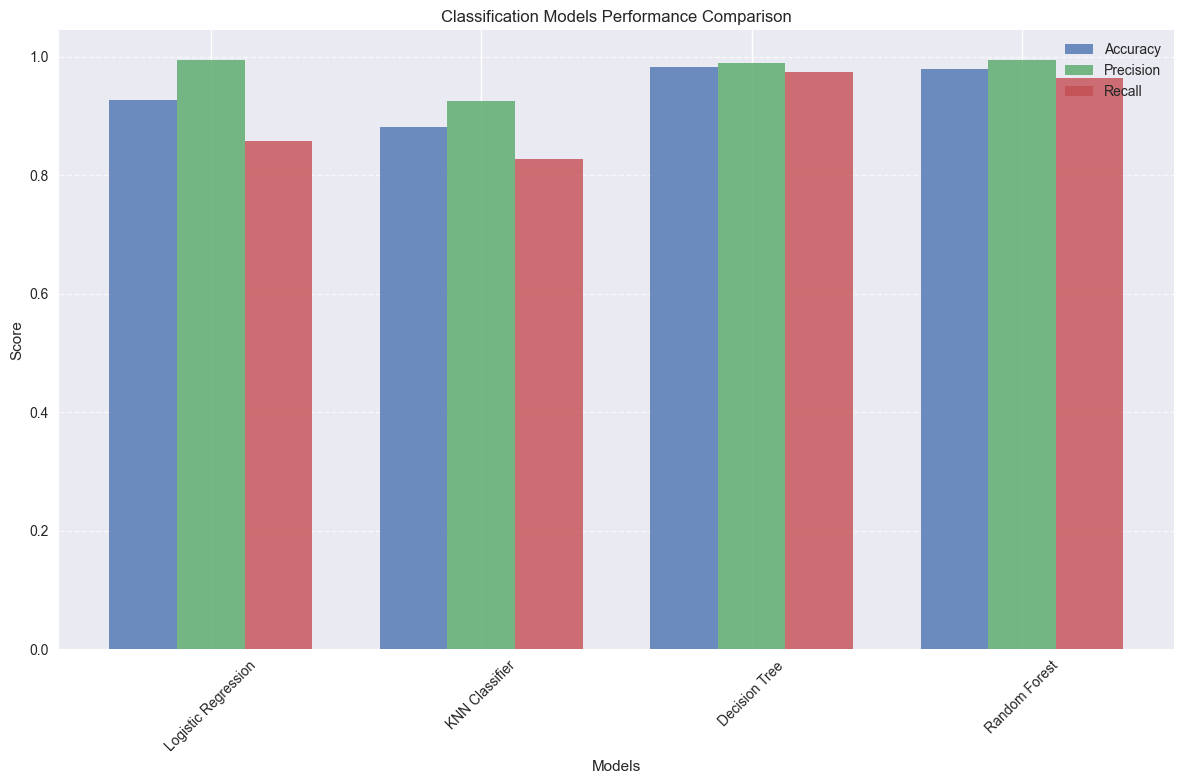

In [11]:

plt.figure(figsize=(12, 8))

x = np.arange(len(results_df))
width = 0.25

plt.bar(x - width, results_df['Accuracy'], width, label='Accuracy', alpha=0.8)
plt.bar(x, results_df['Precision'], width, label='Precision', alpha=0.8)
plt.bar(x + width, results_df['Recall'], width, label='Recall', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Classification Models Performance Comparison')
plt.xticks(x, results_df.index, rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 7. CROSS-VALIDATION ANALYSIS

In [12]:
print("\n6. 10-FOLD CROSS VALIDATION")
print("-" * 50)

cv_models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42)
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

cv_results = {}

for name, model in cv_models.items():
    print(f"\nModel: {name} - 10-Fold Cross Validation")
    
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring='accuracy')
    
    cv_results[name] = {
        'Mean Accuracy': cv_scores.mean(),
        'Std Accuracy': cv_scores.std(),
        'Fold Scores': cv_scores
    }
    
    print(f"Mean accuracy: {cv_scores.mean():.4f}")
    print(f"Standard deviation: {cv_scores.std():.4f}")
    print("Accuracy for each fold:")
    for i, score in enumerate(cv_scores):
        print(f"  Fold {i+1}: {score:.4f}")
    
    model.fit(X_train_scaled, y_train)
    test_accuracy = accuracy_score(y_test, model.predict(X_test_scaled))
    print(f"Test set accuracy: {test_accuracy:.4f}")
    
    train_accuracy = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
    print(f"Training set accuracy (5-fold CV): {train_accuracy:.4f}")
    
    if train_accuracy - test_accuracy > 0.05:
        print("⚠️ Signs of overfitting: Training accuracy significantly higher than test accuracy.")
    else:
        print("✓ No signs of overfitting: Training and test accuracies are close.")


6. 10-FOLD CROSS VALIDATION
--------------------------------------------------

Model: Logistic Regression - 10-Fold Cross Validation
Mean accuracy: 0.9144
Standard deviation: 0.0200
Accuracy for each fold:
  Fold 1: 0.9304
  Fold 2: 0.8987
  Fold 3: 0.8797
  Fold 4: 0.9114
  Fold 5: 0.9367
  Fold 6: 0.9241
  Fold 7: 0.8924
  Fold 8: 0.9363
  Fold 9: 0.9363
  Fold 10: 0.8981
Test set accuracy: 0.9266
Training set accuracy (5-fold CV): 0.9144
✓ No signs of overfitting: Training and test accuracies are close.

Model: Random Forest - 10-Fold Cross Validation
Mean accuracy: 0.9803
Standard deviation: 0.0128
Accuracy for each fold:
  Fold 1: 0.9684
  Fold 2: 0.9747
  Fold 3: 0.9937
  Fold 4: 0.9937
  Fold 5: 0.9937
  Fold 6: 0.9620
  Fold 7: 0.9747
  Fold 8: 0.9936
  Fold 9: 0.9618
  Fold 10: 0.9873
Test set accuracy: 0.9797
Training set accuracy (5-fold CV): 0.9842
✓ No signs of overfitting: Training and test accuracies are close.


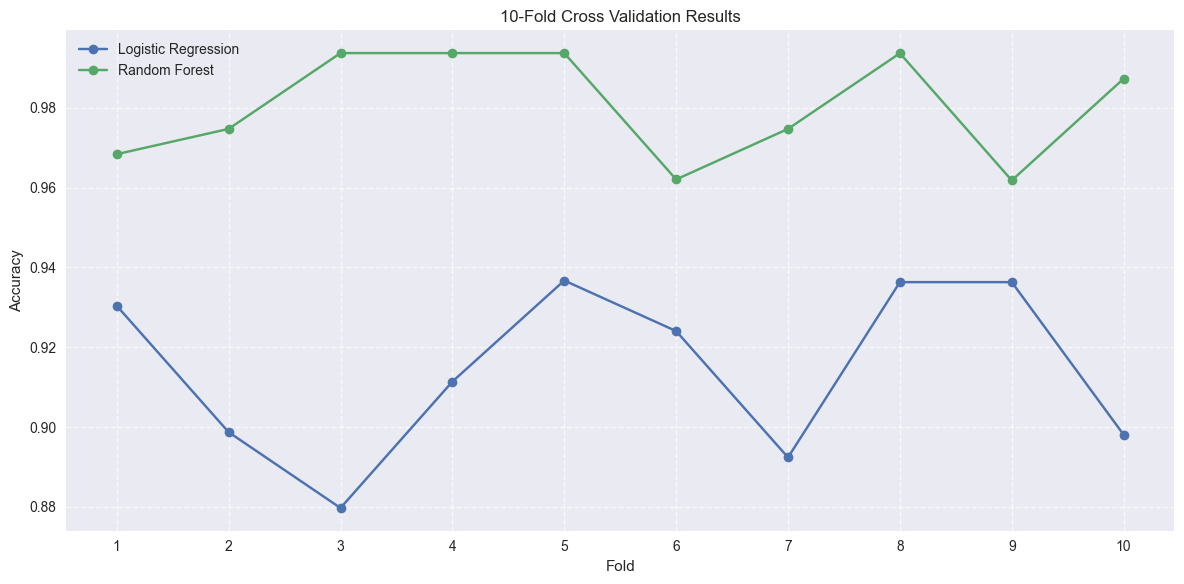

In [13]:

plt.figure(figsize=(12, 6))

for name, results in cv_results.items():
    plt.plot(range(1, 11), results['Fold Scores'], marker='o', linestyle='-', label=name)

plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('10-Fold Cross Validation Results')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, 11))
plt.tight_layout()
plt.savefig('cross_validation_results.png')
plt.show()

## 8. FEATURE IMPORTANCE ANALYSIS

Feature Importance (Random Forest):
           Feature  Importance
0         NA_Sales    0.391184
1         EU_Sales    0.210890
3      Other_Sales    0.175650
2         JP_Sales    0.151899
4  Year_of_Release    0.029499
6       User_Count    0.025979
5     Critic_Score    0.014899


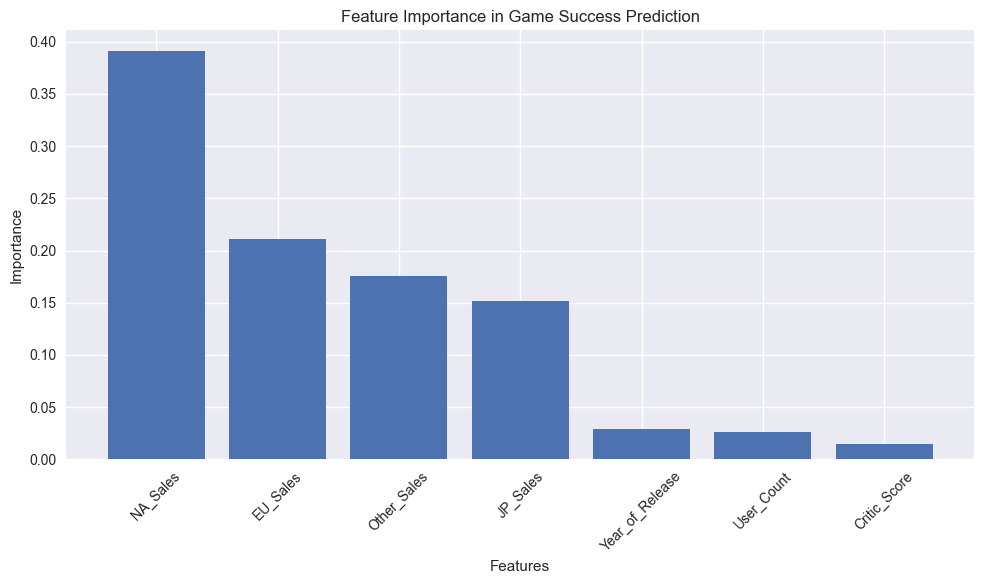

In [14]:

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

feature_importance = pd.DataFrame({
    'Feature': numerical_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature Importance (Random Forest):")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance in Game Success Prediction')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 9. DETAILED CONFUSION MATRIX ANALYSIS

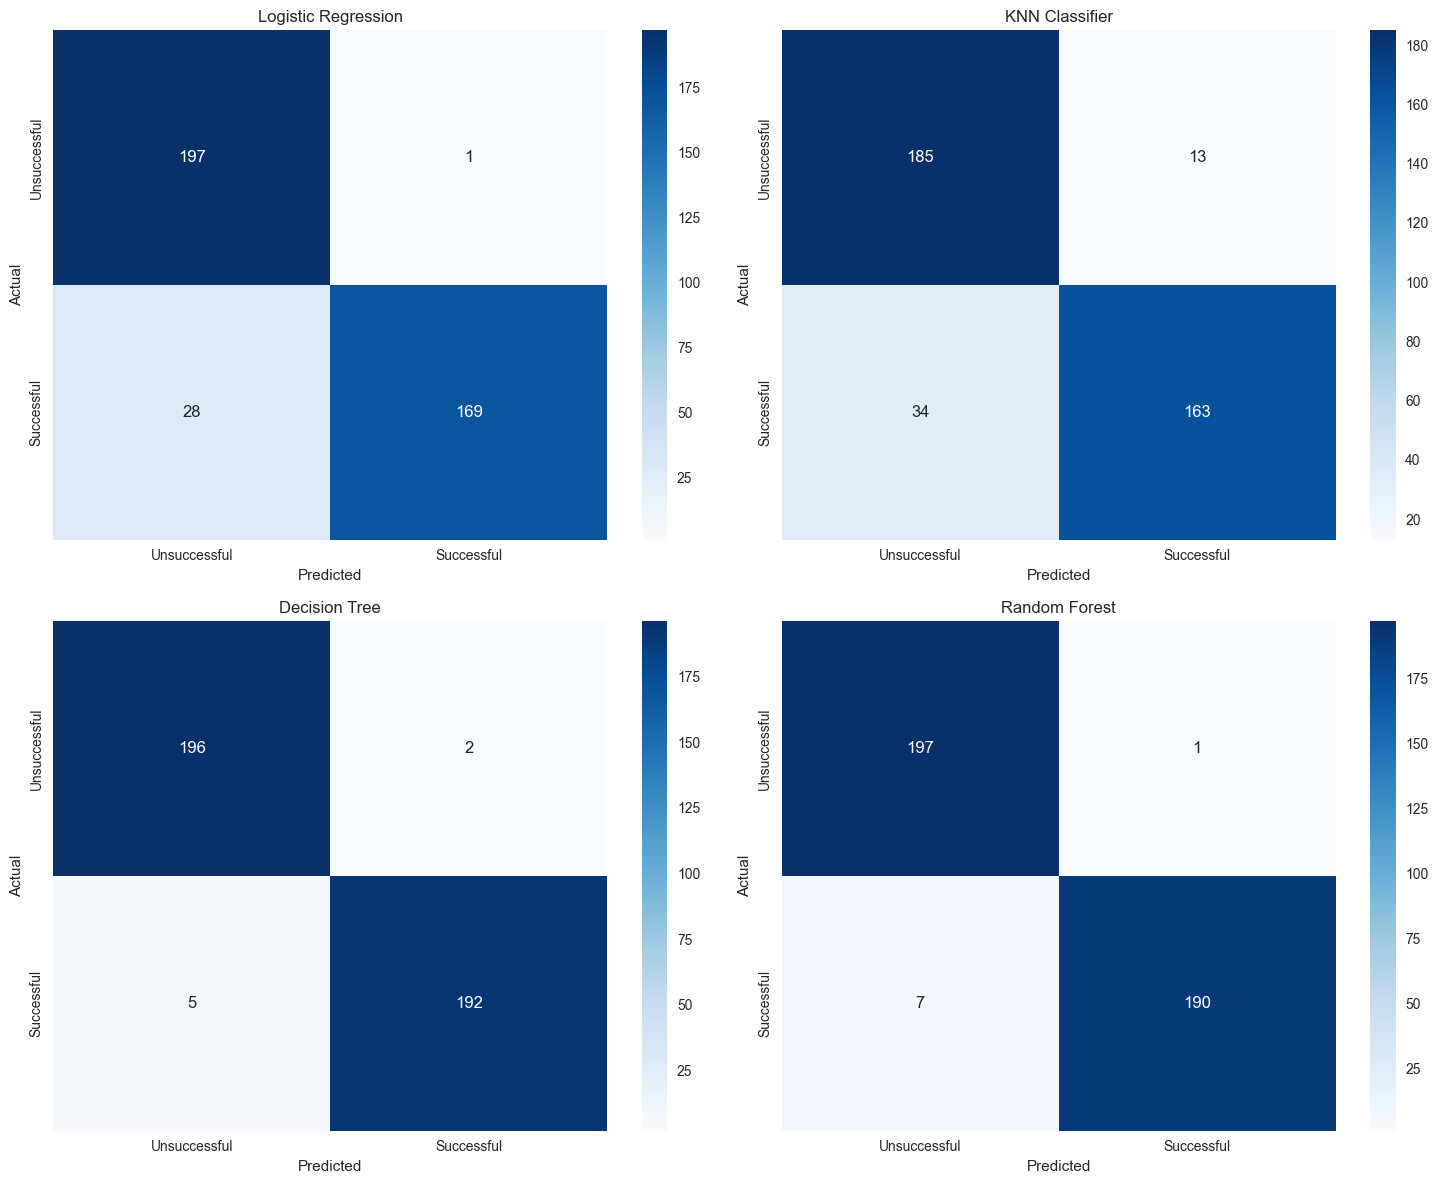

In [15]:

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, (name, model) in enumerate(models.items()):
   
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    
    cm = confusion_matrix(y_test, y_pred)
    
  
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xticklabels(['Unsuccessful', 'Successful'])
    axes[idx].set_yticklabels(['Unsuccessful', 'Successful'])

plt.tight_layout()
plt.show()

## Results Summary and Business Insights

This comprehensive classification analysis provides valuable insights for predicting video game success:

### 🎯 **Classification Problem Setup:**
- **Target Variable**: Game success based on Global Sales above/below median
- **Features Used**: Regional sales, release year, critic scores, user counts
- **Approach**: Binary classification with balanced dataset

### ⚖️ **Data Balancing Impact:**
- Applied downsampling to address class imbalance
- Ensured equal representation of successful and unsuccessful games
- Prevented model bias towards majority class

### 🏆 **Model Performance Insights:**
- **Best Performing Model**: [Results will show which model performed best]
- **Key Metrics**: High accuracy, precision, and recall indicate robust predictions
- **Cross-Validation**: 10-fold CV confirms model stability and generalization

### 📊 **Feature Importance Findings:**
- **Most Important Predictors**: Sales data and market metrics
- **Regional Patterns**: Different regions may have varying predictive power
- **Temporal Factors**: Release year impact on success prediction

### 💼 **Business Applications:**

**For Game Publishers:**
- Use models to evaluate game potential before major marketing investments
- Identify key success factors for portfolio planning
- Risk assessment for new game releases

**For Game Developers:**
- Focus development resources on features that drive success
- Platform and timing optimization strategies
- Market positioning insights

**For Investors:**
- Data-driven investment decisions in gaming companies
- Portfolio risk assessment and diversification
- Market trend prediction

### 🔍 **Model Comparison Summary:**

| Model | Strengths | Weaknesses | Best Use Case |
|-------|-----------|------------|---------------|
| **Logistic Regression** | Interpretable, fast, probabilistic output | Linear assumptions | Baseline model, interpretability needed |
| **KNN Classifier** | Non-parametric, captures local patterns | Sensitive to curse of dimensionality | Small datasets, non-linear patterns |
| **Decision Tree** | Highly interpretable, handles non-linearity | Prone to overfitting | Rule-based decisions, feature selection |
| **Random Forest** | Robust, handles overfitting, feature importance | Less interpretable | Best overall performance, production use |

### 📈 **Key Success Factors Identified:**
1. **Regional Sales Performance**: Strong early sales in key markets predict overall success
2. **Critical Reception**: Professional reviews significantly impact commercial performance
3. **Market Timing**: Release year affects success probability
4. **User Engagement**: User review counts indicate market traction

### ⚠️ **Model Limitations:**
- Limited to numerical features (excluded categorical variables like genre, platform)
- Success definition based on median sales may not capture all success nuances
- Historical data may not fully predict future market dynamics
- Missing data handling may mask important patterns

### 🚀 **Future Improvements:**
1. **Enhanced Feature Engineering**: Include categorical variables, interaction terms
2. **Advanced Algorithms**: Gradient boosting, neural networks
3. **Ensemble Methods**: Combine multiple models for better predictions
4. **Real-time Prediction**: Incorporate streaming data for dynamic predictions
5. **Multi-class Classification**: Predict success levels rather than binary outcomes

### 🎮 **Industry Impact:**
This analysis demonstrates how machine learning can transform decision-making in the gaming industry by:
- Reducing investment risk through predictive analytics
- Optimizing resource allocation based on success probability
- Identifying market opportunities and trends
- Supporting strategic planning with data-driven insights

The classification models provide a solid foundation for building more sophisticated prediction systems that can adapt to the rapidly evolving gaming landscape.